<a href="https://colab.research.google.com/github/KiambiC9/Numerical-Simulation-Monte-Carlo-Simulation/blob/main/204843_Assignment_1_q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math
from math import sqrt, exp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm

**Question 2: Monte Carlo**

A)

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
S0 = 100.0      # initial stock price
r = 0.05        # risk-free rate
sigma = 0.2     # volatility
T = 1.0         # maturity
N = 50          # number of monitoring points
M = 100_000     # number of Monte Carlo simulations

dt = T / N
sqrt_dt = np.sqrt(dt)

# Generate random standard normals (M x N)
Z = np.random.normal(size=(M, N))

# Initialize arrays
S = np.full(M, S0, dtype=np.float64)
sum_S = np.zeros(M, dtype=np.float64)

# Simulate paths using Euler discretization
for i in range(N):
    S = S * (1 + r*dt + sigma * sqrt_dt * Z[:, i])
    sum_S += S

# Computation of average strike and terminal price
avg_S = sum_S / N
ST = S.copy()

# Computation of Payoff
payoffs = np.maximum(ST - avg_S, 0.0)

# Discounted Monte Carlo estimator
discount_factor = np.exp(-r * T)
discounted_payoffs = discount_factor * payoffs
price_estimate = np.mean(discounted_payoffs)

# Standard error and 95% confidence interval
se = np.std(discounted_payoffs, ddof=1) / np.sqrt(M)
ci_lower = price_estimate - 1.96 * se
ci_upper = price_estimate + 1.96 * se

# Results
print(f"Asian Average-Strike Call Option Price Estimate: {price_estimate:.5f}")
print(f"Standard Error: {se:.5f}")
print(f"95% Confidence Interval: [{ci_lower:.5f}, {ci_upper:.5f}]")

Asian Average-Strike Call Option Price Estimate: 5.75199
Standard Error: 0.02637
95% Confidence Interval: [5.70030, 5.80367]


B) Control Variate

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

def norm_cdf_array(x):
    return 0.5 * (1.0 + np.vectorize(math.erf)(x / math.sqrt(2.0)))

# Parameters as initially set in (a)
S0 = 100.0
r = 0.05
sigma = 0.2
T = 1.0
N = 50
M = 100_000

dt = T / N
times = np.linspace(dt, T, N)

# Moments for ln G (geometric average)
mean_lnS_t = np.log(S0) + (r - 0.5 * sigma**2) * times
min_t = np.minimum.outer(times, times)
cov_lnS = sigma**2 * min_t

mean_lnG = mean_lnS_t.mean()
var_lnG = cov_lnS.mean()

# Cov(ln S_T, ln G)
cov_lnST_lnG = sigma**2 * times.mean()
mean_lnST = np.log(S0) + (r - 0.5*sigma**2) * T
var_lnST = sigma**2 * T

cov_ST_G = cov_lnST_lnG
var_cond_lnST = var_lnST - cov_ST_G**2 / var_lnG
sigma_u = np.sqrt(var_cond_lnST)

# Analytic expectation of geometric payoff
L = 200_000
v_samples = np.random.normal(loc=mean_lnG, scale=np.sqrt(var_lnG), size=L)
mu_lnST_given_v = mean_lnST + (cov_ST_G / var_lnG) * (v_samples - mean_lnG)
mu_u = mu_lnST_given_v - v_samples

a = (mu_u + sigma_u**2) / sigma_u
b = mu_u / sigma_u
term1 = np.exp(mu_u + 0.5 * sigma_u**2) * norm_cdf_array(a)
term2 = norm_cdf_array(b)
cond_expect = term1 - term2
EY = np.mean(np.exp(v_samples) * cond_expect)   # E[Y]

print(f"Estimated analytic E[Y] (via numerical integration, L={L}): {EY:.8f}")

# Main MC (exact GBM) to get X and Y samples
Zs = np.random.normal(size=(M, N))
S = np.full(M, S0, dtype=np.float64)
prod_S = np.ones(M, dtype=np.float64)
sum_S = np.zeros(M, dtype=np.float64)

for i in range(N):
    S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Zs[:, i])
    prod_S *= S
    sum_S += S

avg_arith = sum_S / N
G_geom = prod_S ** (1.0 / N)
ST = S.copy()

X = np.maximum(ST - avg_arith, 0.0)   # arithmetic payoff
Y = np.maximum(ST - G_geom, 0.0)     # geometric payoff

cov_XY = np.cov(X, Y, ddof=1)[0, 1]
var_Y = np.var(Y, ddof=1)
lam = cov_XY / var_Y

print(f"Estimated lambda (control variate coefficient): {lam:.6f}")

# Adjusted estimator and discounted CCV
Z_adj = X + lam * (EY - Y)
discount = np.exp(-r * T)
discounted_Z = discount * Z_adj
CCV_estimate = np.mean(discounted_Z)
se_CCV = np.std(discounted_Z, ddof=1) / np.sqrt(M)
ci_lower = CCV_estimate - 1.96 * se_CCV
ci_upper = CCV_estimate + 1.96 * se_CCV

print(f"\nControl variate estimate (CCV): {CCV_estimate:.6f}")
print(f"Standard error: {se_CCV:.6f}")
print(f"95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")

Estimated analytic E[Y] (via numerical integration, L=200000): 6.28860316
Estimated lambda (control variate coefficient): 0.967800

Control variate estimate (CCV): 5.773328
Standard error: 0.000659
95% CI: [5.772037, 5.774619]


C) The precentage reduction in variance:

*Arithmetic *

Asian Average-Strike Call Option Price Estimate: 5.75199

Standard Error: 0.02637

95% Confidence Interval: [5.70030, 5.80367]

Variance: 0.02637^2

*Geometric - Control Variates:*

Control variate estimate (CCV): 5.773328

Standard error: 0.000659

95% CI: [5.772037, 5.774619]

Variance: 0.000659^2

In [4]:
# Variances for arithmetic MC and Control variate geometric
Ar_se = 0.02637   # standard error of crude MC
CV_se = 0.000659  # standard error of control variate

Ar_var = Ar_se**2
CV_var = CV_se**2

# Percentage variance reduction
reduction = (Ar_var - CV_var) / Ar_var * 100

print(f"Crude variance     = {Ar_var:.10f}")
print(f"Control variate var= {CV_var:.10f}")
print(f"Variance reduction = {reduction:.4f}%")

Crude variance     = 0.0006953769
Control variate var= 0.0000004343
Variance reduction = 99.9375%


D) Scenario analysis: The number of time steps N increased:

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

def norm_cdf_array(x):
    return 0.5 * (1.0 + np.vectorize(math.erf)(x / math.sqrt(2.0)))

# Parameters as initially set in (a)
S0 = 100.0
r = 0.05
sigma = 0.2
T = 1.0
M = 100_000 # Using the original M value

N_values = [20, 50, 100, 200, 500, 1000]
ccv_estimates_N = []
se_ccv_values_N = []
ci_lower_values_N = []
ci_upper_values_N = []

for N in N_values:
    dt = T / N
    times = np.linspace(dt, T, N)

    # Moments for ln G (geometric average) - these depend on N
    mean_lnS_t = np.log(S0) + (r - 0.5 * sigma**2) * times
    min_t = np.minimum.outer(times, times)
    cov_lnS = sigma**2 * min_t

    mean_lnG = mean_lnS_t.mean()
    var_lnG = cov_lnS.mean()

    # Cov(ln S_T, ln G)
    cov_lnST_lnG = sigma**2 * times.mean()
    mean_lnST = np.log(S0) + (r - 0.5*sigma**2) * T
    var_lnST = sigma**2 * T

    cov_ST_G = cov_lnST_lnG
    var_cond_lnST = var_lnST - cov_ST_G**2 / var_lnG
    sigma_u = np.sqrt(var_cond_lnST)

    # Analytic expectation of geometric payoff - also depends on N
    L = 200_000
    v_samples = np.random.normal(loc=mean_lnG, scale=np.sqrt(var_lnG), size=L)
    mu_lnST_given_v = mean_lnST + (cov_ST_G / var_lnG) * (v_samples - mean_lnG)
    mu_u = mu_lnST_given_v - v_samples

    a = (mu_u + sigma_u**2) / sigma_u
    b = mu_u / sigma_u
    term1 = np.exp(mu_u + 0.5 * sigma_u**2) * norm_cdf_array(a)
    term2 = norm_cdf_array(b)
    cond_expect = term1 - term2
    EY = np.mean(np.exp(v_samples) * cond_expect)   # E[Y]

    # Main MC (exact GBM) to get X and Y samples
    Zs = np.random.normal(size=(M, N))
    S = np.full(M, S0, dtype=np.float64)
    prod_S = np.ones(M, dtype=np.float64)
    sum_S = np.zeros(M, dtype=np.float64)

    sqrt_dt = np.sqrt(dt)
    for i in range(N):
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Zs[:, i])
        prod_S *= S
        sum_S += S

    avg_arith = sum_S / N
    G_geom = prod_S ** (1.0 / N)
    ST = S.copy()

    X = np.maximum(ST - avg_arith, 0.0)   # arithmetic payoff
    Y = np.maximum(ST - G_geom, 0.0)     # geometric payoff

    cov_XY = np.cov(X, Y, ddof=1)[0, 1]
    var_Y = np.var(Y, ddof=1)
    lam = cov_XY / var_Y

    # Adjusted estimator and discounted CCV
    Z_adj = X + lam * (EY - Y)
    discount = np.exp(-r * T)
    discounted_Z = discount * Z_adj
    CCV_estimate = np.mean(discounted_Z)
    se_CCV = np.std(discounted_Z, ddof=1) / np.sqrt(M)
    ci_lower = CCV_estimate - 1.96 * se_CCV
    ci_upper = CCV_estimate + 1.96 * se_CCV

    ccv_estimates_N.append(CCV_estimate)
    se_ccv_values_N.append(se_CCV)
    ci_lower_values_N.append(ci_lower)
    ci_upper_values_N.append(ci_upper)

results_df_N = pd.DataFrame({
    'Number of Steps (N)': N_values,
    'CCV Estimate': ccv_estimates_N,
    'Standard Error': se_ccv_values_N,
    '95% CI Lower Bound': ci_lower_values_N,
    '95% CI Upper Bound': ci_upper_values_N
})

display(results_df_N)

/tmp/ipython-input-2512375582.py:63: RuntimeWarning: overflow encountered in multiply
  prod_S *= S
/tmp/ipython-input-2512375582.py:75: RuntimeWarning: invalid value encountered in scalar divide
  lam = cov_XY / var_Y


,Number of Steps (N),CCV Estimate,Standard Error,95% CI Lower Bound,95% CI Upper Bound
0,20,5.631640,0.000636,5.630393,5.632887
1,50,5.785692,0.000652,5.784415,5.786970
2,100,5.819892,0.000662,5.818595,5.821190
3,200,NaN,NaN,NaN,NaN
4,500,NaN,NaN,NaN,NaN
5,1000,NaN,NaN,NaN,NaN


Increase of the number of time steps from 50 to 100, the SE reduces, But from 100 steps, any greater steps yields invalid SE.

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

def norm_cdf_array(x):
    return 0.5 * (1.0 + np.vectorize(math.erf)(x / math.sqrt(2.0)))

# Parameters as initially set in (a)
S0 = 100.0
r = 0.05
sigma = 0.2 # Using the original sigma value
T = 1.0
N = 50

M_values = [10000, 50000, 100000, 500000, 1000000]
ccv_estimates_M = []
se_ccv_values_M = []
ci_lower_values_M = []
ci_upper_values_M = []

dt = T / N
times = np.linspace(dt, T, N)

# Moments for ln G (geometric average) - these are independent of M
mean_lnS_t = np.log(S0) + (r - 0.5 * sigma**2) * times
min_t = np.minimum.outer(times, times)
cov_lnS = sigma**2 * min_t

mean_lnG = mean_lnS_t.mean()
var_lnG = cov_lnS.mean()

# Cov(ln S_T, ln G)
cov_lnST_lnG = sigma**2 * times.mean()
mean_lnST = np.log(S0) + (r - 0.5*sigma**2) * T
var_lnST = sigma**2 * T

cov_ST_G = cov_lnST_lnG
var_cond_lnST = var_lnST - cov_ST_G**2 / var_lnG
sigma_u = np.sqrt(var_cond_lnST)

# Analytic expectation of geometric payoff - also independent of M
L = 200_000
v_samples = np.random.normal(loc=mean_lnG, scale=np.sqrt(var_lnG), size=L)
mu_lnST_given_v = mean_lnST + (cov_ST_G / var_lnG) * (v_samples - mean_lnG)
mu_u = mu_lnST_given_v - v_samples

a = (mu_u + sigma_u**2) / sigma_u
b = mu_u / sigma_u
term1 = np.exp(mu_u + 0.5 * sigma_u**2) * norm_cdf_array(a)
term2 = norm_cdf_array(b)
cond_expect = term1 - term2
EY = np.mean(np.exp(v_samples) * cond_expect)   # E[Y]


for M in M_values:
    # Main MC (exact GBM) to get X and Y samples
    Zs = np.random.normal(size=(M, N))
    S = np.full(M, S0, dtype=np.float64)
    prod_S = np.ones(M, dtype=np.float64)
    sum_S = np.zeros(M, dtype=np.float64)

    sqrt_dt = np.sqrt(dt)
    for i in range(N):
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Zs[:, i])
        prod_S *= S
        sum_S += S

    avg_arith = sum_S / N
    G_geom = prod_S ** (1.0 / N)
    ST = S.copy()

    X = np.maximum(ST - avg_arith, 0.0)   # arithmetic payoff
    Y = np.maximum(ST - G_geom, 0.0)     # geometric payoff

    cov_XY = np.cov(X, Y, ddof=1)[0, 1]
    var_Y = np.var(Y, ddof=1)
    lam = cov_XY / var_Y

    # Adjusted estimator and discounted CCV
    Z_adj = X + lam * (EY - Y)
    discount = np.exp(-r * T)
    discounted_Z = discount * Z_adj
    CCV_estimate = np.mean(discounted_Z)
    se_CCV = np.std(discounted_Z, ddof=1) / np.sqrt(M)
    ci_lower = CCV_estimate - 1.96 * se_CCV
    ci_upper = CCV_estimate + 1.96 * se_CCV

    ccv_estimates_M.append(CCV_estimate)
    se_ccv_values_M.append(se_CCV)
    ci_lower_values_M.append(ci_lower)
    ci_upper_values_M.append(ci_upper)

results_df_M = pd.DataFrame({
    'Number of Simulations (M)': M_values,
    'CCV Estimate': ccv_estimates_M,
    'Standard Error': se_ccv_values_M,
    '95% CI Lower Bound': ci_lower_values_M,
    '95% CI Upper Bound': ci_upper_values_M
})

display(results_df_M)

,Number of Simulations (M),CCV Estimate,Standard Error,95% CI Lower Bound,95% CI Upper Bound
0,10000,5.774868,0.002056,5.770838,5.778899
1,50000,5.771671,0.000945,5.769820,5.773522
2,100000,5.774258,0.000650,5.772984,5.775532
3,500000,5.773429,0.000292,5.772856,5.774001
4,1000000,5.773234,0.000208,5.772828,5.773641


Increase in number of simulations, M reduces the Standard error, For this case we have increased the simulations from 100,000 to 1,000,000. The confidence interval shrinks with the increase of simulations as they are the base of the function.

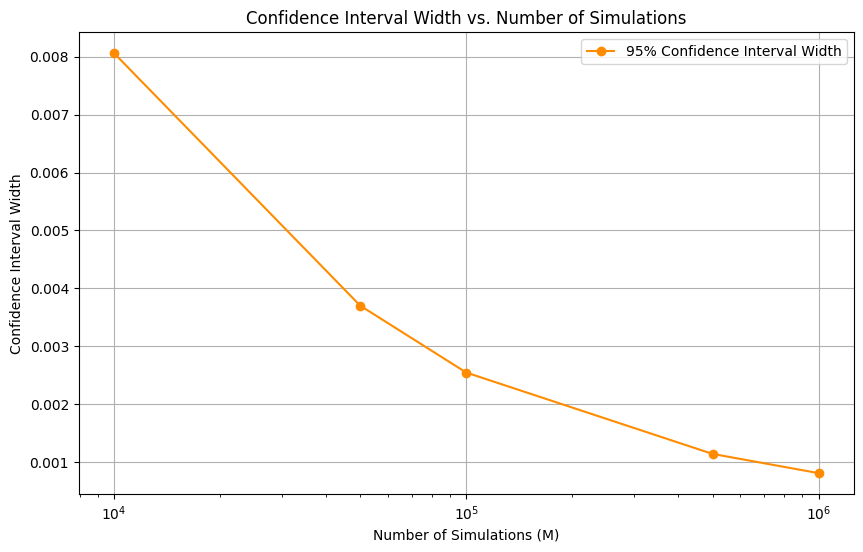

In [7]:
plt.figure(figsize=(10, 6))
# Calculate the width of the confidence interval
ci_width = results_df_M['95% CI Upper Bound'] - results_df_M['95% CI Lower Bound']
plt.plot(results_df_M['Number of Simulations (M)'], ci_width, label='95% Confidence Interval Width', marker='o', color='darkorange')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('Confidence Interval Width')
plt.title('Confidence Interval Width vs. Number of Simulations')
plt.xscale('log') # Use log scale for M as values vary greatly
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Set random seed for reproducibility
np.random.seed(42)

def norm_cdf_array(x):
    return 0.5 * (1.0 + np.vectorize(math.erf)(x / math.sqrt(2.0)))

# Parameters as initially set in (a)
S0 = 100.0
r = 0.05
T = 1.0
N = 50
M = 100_000

dt = T / N
times = np.linspace(dt, T, N)

sigma_values = [0.02, 0.04, 0.08, 0.2, 0.4, 0.6]
ccv_estimates = []
se_ccv_values = []
ci_lower_values = []
ci_upper_values = []

for sigma in sigma_values:
    # Moments for ln G (geometric average)
    mean_lnS_t = np.log(S0) + (r - 0.5 * sigma**2) * times
    min_t = np.minimum.outer(times, times)
    cov_lnS = sigma**2 * min_t

    mean_lnG = mean_lnS_t.mean()
    var_lnG = cov_lnS.mean()

    # Cov(ln S_T, ln G)
    cov_lnST_lnG = sigma**2 * times.mean()
    mean_lnST = np.log(S0) + (r - 0.5*sigma**2) * T
    var_lnST = sigma**2 * T

    cov_ST_G = cov_lnST_lnG
    var_cond_lnST = var_lnST - cov_ST_G**2 / var_lnG
    sigma_u = np.sqrt(var_cond_lnST)

    # Analytic expectation of geometric payoff
    L = 200_000
    v_samples = np.random.normal(loc=mean_lnG, scale=np.sqrt(var_lnG), size=L)
    mu_lnST_given_v = mean_lnST + (cov_ST_G / var_lnG) * (v_samples - mean_lnG)
    mu_u = mu_lnST_given_v - v_samples

    a = (mu_u + sigma_u**2) / sigma_u
    b = mu_u / sigma_u
    term1 = np.exp(mu_u + 0.5 * sigma_u**2) * norm_cdf_array(a)
    term2 = norm_cdf_array(b)
    cond_expect = term1 - term2
    EY = np.mean(np.exp(v_samples) * cond_expect)   # E[Y]

    # Main MC (exact GBM) to get X and Y samples
    Zs = np.random.normal(size=(M, N))
    S = np.full(M, S0, dtype=np.float64)
    prod_S = np.ones(M, dtype=np.float64)
    sum_S = np.zeros(M, dtype=np.float64)

    sqrt_dt = np.sqrt(dt)
    for i in range(N):
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Zs[:, i])
        prod_S *= S
        sum_S += S

    avg_arith = sum_S / N
    G_geom = prod_S ** (1.0 / N)
    ST = S.copy()

    X = np.maximum(ST - avg_arith, 0.0)   # arithmetic payoff
    Y = np.maximum(ST - G_geom, 0.0)     # geometric payoff

    cov_XY = np.cov(X, Y, ddof=1)[0, 1]
    var_Y = np.var(Y, ddof=1)
    lam = cov_XY / var_Y

    # Adjusted estimator and discounted CCV
    Z_adj = X + lam * (EY - Y)
    discount = np.exp(-r * T)
    discounted_Z = discount * Z_adj
    CCV_estimate = np.mean(discounted_Z)
    se_CCV = np.std(discounted_Z, ddof=1) / np.sqrt(M)
    ci_lower = CCV_estimate - 1.96 * se_CCV
    ci_upper = CCV_estimate + 1.96 * se_CCV

    ccv_estimates.append(CCV_estimate)
    se_ccv_values.append(se_CCV)
    ci_lower_values.append(ci_lower)
    ci_upper_values.append(ci_upper)


print("Sigma Values:", sigma_values)
print("CCV Estimates:", ccv_estimates)
print("Standard Errors:", se_ccv_values)
print("95% Confidence Interval Lower Bounds:", ci_lower_values)
print("95% Confidence Interval Upper Bounds:", ci_upper_values)

Sigma Values: [0.02, 0.04, 0.08, 0.2, 0.4, 0.6]
CCV Estimates: [np.float64(2.4168959803655996), np.float64(2.5731680517980884), np.float64(3.243048846411588), np.float64(5.783594650409389), np.float64(10.144650846440792), np.float64(14.554093047493755)]
Standard Errors: [np.float64(1.876388751916933e-05), np.float64(4.466549273765729e-05), np.float64(0.00012952061731286128), np.float64(0.0006481178740361012), np.float64(0.002604183679389156), np.float64(0.006141446306893482)]
95% Confidence Interval Lower Bounds: [np.float64(2.416859203146062), np.float64(2.5730805074323224), np.float64(3.2427949860016545), np.float64(5.782324339376278), np.float64(10.139546646429189), np.float64(14.542055812732244)]
95% Confidence Interval Upper Bounds: [np.float64(2.4169327575851374), np.float64(2.5732555961638544), np.float64(3.243302706821521), np.float64(5.7848649614425005), np.float64(10.149755046452395), np.float64(14.566130282255266)]


In [9]:
results_df = pd.DataFrame({
    'Sigma Value': sigma_values,
    'CCV Estimate': ccv_estimates,
    'Standard Error': se_ccv_values,
    '95% CI Lower Bound': ci_lower_values,
    '95% CI Upper Bound': ci_upper_values
})

display(results_df)

,Sigma Value,CCV Estimate,Standard Error,95% CI Lower Bound,95% CI Upper Bound
0,0.02,2.416896,0.000019,2.416859,2.416933
1,0.04,2.573168,0.000045,2.573081,2.573256
2,0.08,3.243049,0.000130,3.242795,3.243303
3,0.20,5.783595,0.000648,5.782324,5.784865
4,0.40,10.144651,0.002604,10.139547,10.149755
5,0.60,14.554093,0.006141,14.542056,14.566130


An increase in volatility increase the SE. While, decrease in volatility decreases the SE.

**Discuss the efficiency of Control Variate as a variance reduction method**

The control variate method is efficient when the control is highly correlated with the target. Thus, significantly reducing the variance with fewer paths.